In [132]:
import pandas as pd
import numpy as np
import os, sys
from response import response, response_legacy
import matplotlib.pyplot as plt
import sklearn

------------

In [133]:
data = pd.read_csv('data/run_30413/fit_results_run_30413_no_avg.txt', sep='\t')
data.columns = data.columns.str.strip().str.replace(' ', '')
data.head()

,#Ch.#,t,E(t),A_0,E(A_0),t_p,E(t_p),k3,E(k3),k4,E(k4),k5,E(k5),k6,E(k6),Chi2/DOF
0,5.008733,0.009035,83064.54115,631.653,2.250056,0.012383,0.431505,0.043863,0.690926,0.019752,0.431485,0.043861,0.322236,0.005990,10.837975,NaN
1,5.014668,0.008637,88813.00258,1574.470,2.185990,0.010328,0.958992,0.017475,1.248665,0.024367,0.065162,0.003971,0.066870,0.004085,11.788794,NaN
2,5.028058,0.008975,82152.01742,665.526,2.212939,0.012120,0.475459,0.115498,0.700305,0.027182,0.475393,0.115472,0.377476,0.011649,7.817971,NaN
3,5.050278,0.008644,77046.19645,449.523,2.043111,0.007093,0.161044,0.002370,0.253107,0.004593,0.161035,0.002370,0.099146,0.001443,6.091413,NaN
4,5.020794,0.008312,88855.94059,7188.340,2.269399,0.010159,0.900172,0.015525,1.179171,0.026359,0.065855,0.005066,0.063880,0.004908,7.904888,NaN


-------------

In [134]:
# shift data columns to the right
columns = data.columns
data = data.reset_index()
data.drop(columns[-1], axis=1, inplace=True)
data.columns = columns
data.head()

,#Ch.#,t,E(t),A_0,E(A_0),t_p,E(t_p),k3,E(k3),k4,E(k4),k5,E(k5),k6,E(k6),Chi2/DOF
0,0,5.008733,0.009035,83064.54115,631.653,2.250056,0.012383,0.431505,0.043863,0.690926,0.019752,0.431485,0.043861,0.322236,0.005990,10.837975
1,1,5.014668,0.008637,88813.00258,1574.470,2.185990,0.010328,0.958992,0.017475,1.248665,0.024367,0.065162,0.003971,0.066870,0.004085,11.788794
2,2,5.028058,0.008975,82152.01742,665.526,2.212939,0.012120,0.475459,0.115498,0.700305,0.027182,0.475393,0.115472,0.377476,0.011649,7.817971
3,3,5.050278,0.008644,77046.19645,449.523,2.043111,0.007093,0.161044,0.002370,0.253107,0.004593,0.161035,0.002370,0.099146,0.001443,6.091413
4,4,5.020794,0.008312,88855.94059,7188.340,2.269399,0.010159,0.900172,0.015525,1.179171,0.026359,0.065855,0.005066,0.063880,0.004908,7.904888


In [135]:
response_params = ['t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6']
tmpdata = data.copy()
x = np.linspace(tmpdata['t'].iloc[2152], tmpdata['t'].iloc[2152]+70, 70)
par0 = list(tmpdata[response_params].iloc[2152])

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_22520/432241104.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Ticks (0.512$\mu$s/Tick)')


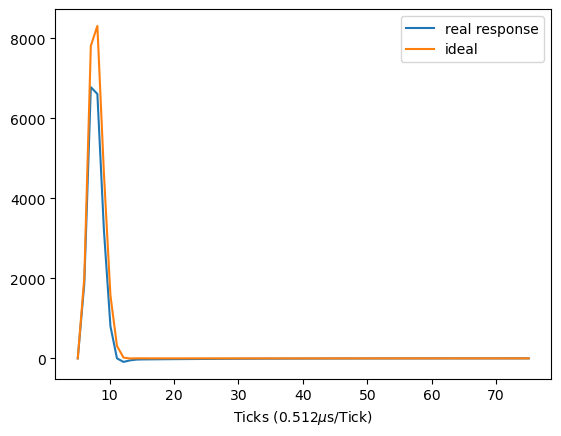

In [136]:
R = response(x=x, par=par0)
R_ideal = response_legacy(x=x, par=par0)

plt.figure()
plt.plot(x, R, label='real response')
plt.plot(x, R_ideal, label='ideal')
plt.xlabel('Ticks (0.512$\mu$s/Tick)')
plt.legend()
plt.show()

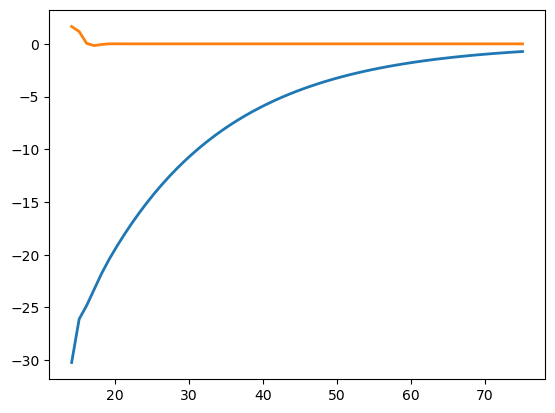

In [137]:
pos_peak = np.argmax(R)
# considering the peak time is 2us and each tick corresponds to 0.512 us, there are at most 5 ticks from the peak to the pedestal.
xtail = x[pos_peak+7:]
plt.figure()
plt.plot(x[pos_peak+7:], R[pos_peak+7:], linewidth=2)
plt.plot(xtail, R_ideal[pos_peak+7:], linewidth=2)
plt.show()

In [138]:
from scipy import interpolate

def find_intersection(x1, y1, x2, y2):
    """
    Find intersection of two curves using interpolation
    
    Parameters:
    x1, y1: coordinates of first curve
    x2, y2: coordinates of second curve
    
    Returns:
    x, y: coordinates of intersection point
    """
    # Create interpolation functions for both curves
    f1 = interpolate.interp1d(x1, y1)
    f2 = interpolate.interp1d(x2, y2)
    
    # Find the overlapping x-range
    x_min = max(x1.min(), x2.min())
    x_max = min(x1.max(), x2.max())
    
    # Create array of x-values to search for intersection
    x = np.linspace(x_min, x_max, 10000)
    
    # Calculate y-values for both functions
    y1_interp = f1(x)
    y2_interp = f2(x)
    
    # # Find where the difference is closest to zero
    idx = np.argmin(np.abs(y1_interp - y2_interp))
   
    return x[idx], y1_interp[idx]

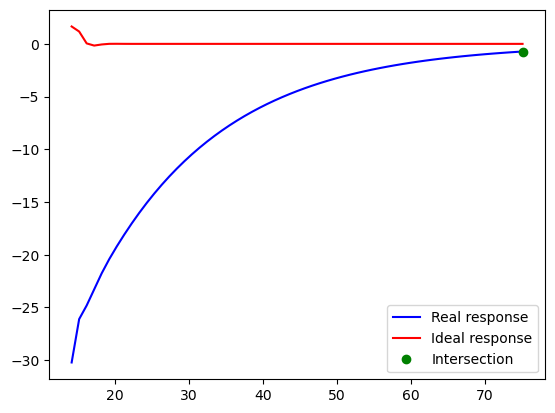

In [139]:
x1 = x[pos_peak+7:]
y1 = R[pos_peak+7:]
x2 = x[pos_peak+7:]
y2 = R_ideal[pos_peak+7:]

# Find intersection
x_intersect, y_intersect = find_intersection(x1,y1,x2, y2)
# mask = x1 <= x_intersect
mask = x1==x1
# Plot the results
plt.plot(x1[mask], y1[mask], 'b-', label='Real response')
plt.plot(x2[mask], y2[mask], 'r-', label='Ideal response')
plt.plot(x_intersect, y_intersect, 'go', label='Intersection')
# plt.plot(x,R)
plt.legend()
plt.show()

In [140]:
from scipy import integrate

def local_average_convolve(arr, window_size=3):
    # create weights for averaging
    weights = np.ones(window_size) / window_size
    # calculate moving average
    avg = np.convolve(arr, weights, mode='valid')
    return avg

integrals_R_selected = []
integrals_R_ideal_selected = []
max_deviations = []
time_peaks_diff = []
peak_differences = []
for i in range(len(tmpdata)):
    x = np.linspace(tmpdata['t'].iloc[i], tmpdata['t'].iloc[i]+70, 70)
    par0 = list(tmpdata[response_params].iloc[i])
    # try:
    # calculate the response
    R = response(x=x, par=par0)
    R_ideal = response_legacy(x=x, par=par0)
    # find peak in ideal response
    pos_peak = np.argmax(R_ideal)
    # considering the peak time is 2us and each tick corresponds to 0.512 us, there are at most 5 ticks from the peak to the pedestal.
    xtail = x[pos_peak+6:]
    # find intersection
    x1 = x[pos_peak+6:]
    y1 = R[pos_peak+6:]
    x2 = x[pos_peak+6:]
    y2 = R_ideal[pos_peak+6:]
    x_intersect, y_intersect = find_intersection(x1,y1,x2, y2)
    # select data between pos_peak+6 and x_intersect
    mask = x1 <= x_intersect
    x_selected = x1[mask]
    R_selected = y1[mask]
    R_ideal_selected = y2[mask]
    integral_R_selected = integrate.simpson(x=x_selected, y=R_selected)
    integral_R_ideal_selected = integrate.simpson(x=x_selected, y=R_ideal_selected)
    integrals_R_selected.append(integral_R_selected)
    integrals_R_ideal_selected.append(integral_R_ideal_selected)
    #
    # Deviation between the ideal and real responses:
    # R_avg = local_average_convolve(R, 2)
    # x_avg = local_average_convolve(x, 2)
    # R_ideal_avg = local_average_convolve(R_ideal, 2)
    # deviations = np.abs(R_avg - R_ideal_avg)
    R_avg = local_average_convolve(R_selected, 2)
    x_avg = local_average_convolve(x_selected, 2)
    R_ideal_avg = local_average_convolve(R_ideal_selected, 2)
    deviations = R_avg - R_ideal_avg
    # deviations = R_avg - R_ideal_avg
    max_deviation = np.max(deviations)
    if np.abs(np.min(deviations)) > np.max(deviations):
        max_deviation = np.min(deviations)
    max_deviations.append(max_deviation)
    time_peaks_diff.append(x[np.argmax(R)] - x[pos_peak])
# max_deviations = np.array(max_deviations) / np.max(max_deviations) # maximum deviation normalized to 1

/media/rado/RADO/WORKSPACE/CE_Project/response.py:29: RuntimeWarning: overflow encountered in exp
  (-(k3*k5) + k3*k6 + k5*k6 - pow(k6,2))/(np.exp(k6*t)*(k4 - k6)*(k6 - p0)*(pow(k6,2) + pow(pi1,2) - 2*k6*pr1 + pow(pr1,2))*(pow(k6,2) + pow(pi2,2) - 2*k6*pr2 + pow(pr2,2))) +
/media/rado/RADO/WORKSPACE/CE_Project/response.py:29: RuntimeWarning: overflow encountered in exp
  (-(k3*k5) + k3*k6 + k5*k6 - pow(k6,2))/(np.exp(k6*t)*(k4 - k6)*(k6 - p0)*(pow(k6,2) + pow(pi1,2) - 2*k6*pr1 + pow(pr1,2))*(pow(k6,2) + pow(pi2,2) - 2*k6*pr2 + pow(pr2,2))) +
/media/rado/RADO/WORKSPACE/CE_Project/response.py:29: RuntimeWarning: overflow encountered in exp
  (-(k3*k5) + k3*k6 + k5*k6 - pow(k6,2))/(np.exp(k6*t)*(k4 - k6)*(k6 - p0)*(pow(k6,2) + pow(pi1,2) - 2*k6*pr1 + pow(pr1,2))*(pow(k6,2) + pow(pi2,2) - 2*k6*pr2 + pow(pr2,2))) +
/media/rado/RADO/WORKSPACE/CE_Project/response.py:29: RuntimeWarning: overflow encountered in exp
  (-(k3*k5) + k3*k6 + k5*k6 - pow(k6,2))/(np.exp(k6*t)*(k4 - k6)*(k6 - p0)*(pow(

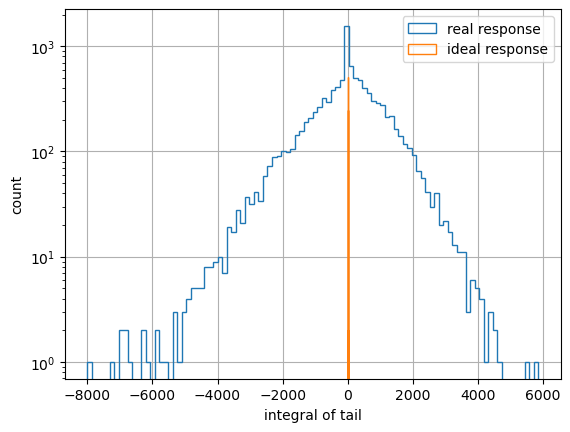

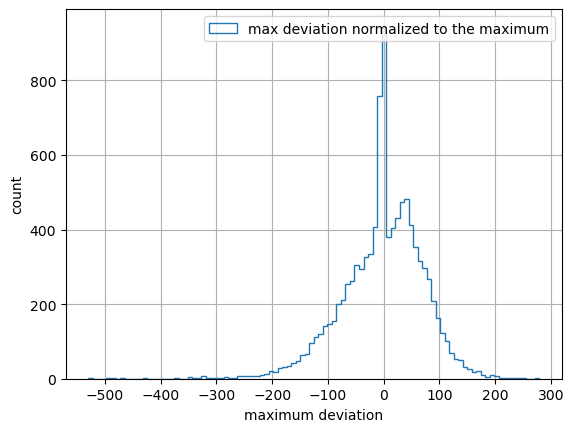

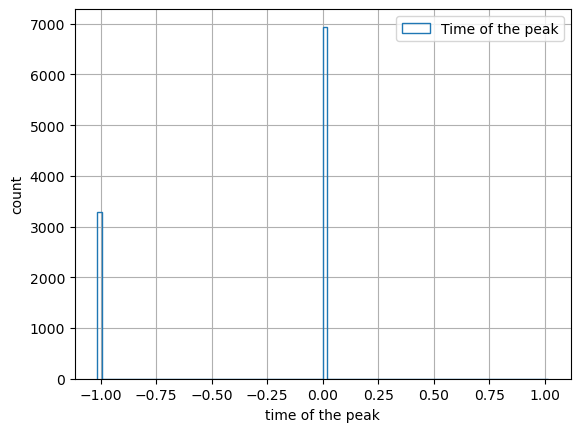

In [141]:
plt.figure()
plt.hist(integrals_R_selected, bins=100, histtype='step', label='real response')
plt.hist(integrals_R_ideal_selected, bins=100, histtype='step', label='ideal response')
plt.xlabel('integral of tail')
plt.ylabel('count')
plt.yscale('log')
# plt.xlim([-2, 10])
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.hist(max_deviations, bins=100, histtype='step', label='max deviation normalized to the maximum')
plt.xlabel('maximum deviation')
plt.ylabel('count')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.hist(time_peaks_diff, bins=100, histtype='step', label='Time of the peak')
plt.xlabel('time of the peak')
plt.ylabel('count')
plt.legend()
plt.grid(True)
plt.show()

In [142]:
tmpdata['integral_R'] = integrals_R_selected
# tmpdata['integral_ideal'] = integrals_R_ideal_selected
tmpdata['max_deviation'] = max_deviations
# tmpdata['time_peak'] = time_peaks_diff

#### Classification

In [143]:
class1_mask = (tmpdata['integral_R'] <= 0) & (tmpdata['max_deviation'] < 0)
class2_mask = (tmpdata['integral_R'] <= 0) & (tmpdata['max_deviation'] > 0)
class3_mask = (tmpdata['integral_R'] > 0) & (tmpdata['max_deviation'] < 0)
class4_mask = (tmpdata['integral_R'] > 0) & (tmpdata['max_deviation'] > 0)
others_mask = (~class1_mask) & (~class2_mask) & (~class3_mask) & (~class4_mask)

In [144]:
class1_df = tmpdata[class1_mask].copy().reset_index().drop('index', axis=1)
class2_df = tmpdata[class2_mask].copy().reset_index().drop('index', axis=1)
class3_df = tmpdata[class3_mask].copy().reset_index().drop('index', axis=1)
class4_df = tmpdata[class4_mask].copy().reset_index().drop('index', axis=1)
others_df = tmpdata[others_mask].copy().reset_index().drop('index', axis=1)

In [145]:
print(len(class2_df))

65


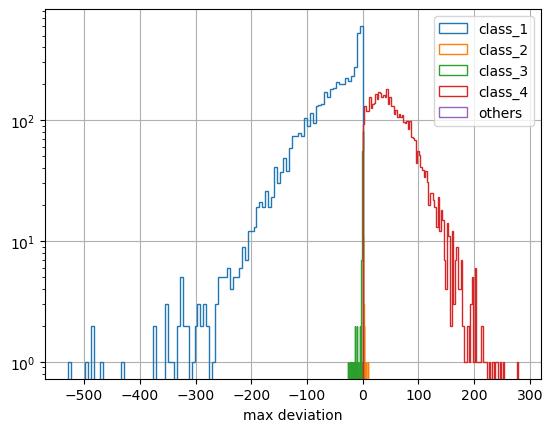

In [146]:
plt.figure()
class1_df['max_deviation'].hist(bins=100, histtype='step', label='class_1')
class2_df['max_deviation'].hist(bins=100, histtype='step', label='class_2')
class3_df['max_deviation'].hist(bins=100, histtype='step', label='class_3')
class4_df['max_deviation'].hist(bins=100, histtype='step', label='class_4')
others_df['max_deviation'].hist(bins=100, histtype='step', label='others')
plt.xlabel('max deviation')
plt.yscale('log')
plt.legend()
plt.show()

In [147]:
len([i for i in class2_mask if i==True])

65

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_22520/2772091602.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Ticks (0.512$\mu$s/Tick)')


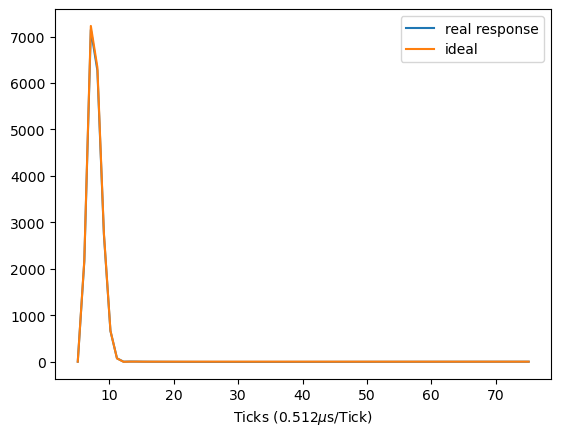

In [148]:
x = np.linspace(class2_df.copy().reset_index()['t'].iloc[10], class2_df.copy().reset_index()['t'].iloc[10]+70, 70)
par0 = list(class2_df.copy().reset_index()[response_params].iloc[10])
R = response(x=x, par=par0)
R_ideal = response_legacy(x=x, par=par0)

plt.figure()
plt.plot(x, R, label='real response')
plt.plot(x, R_ideal, label='ideal')
plt.xlabel('Ticks (0.512$\mu$s/Tick)')
plt.legend()
plt.show()

In [149]:
# class1_df.loc[class1_mask, 'class'] = 'class_1'
# class2_df.loc[class2_mask, 'class'] = 'class_2'
# class3_df.loc[class3_mask, 'class'] = 'class_3'
# class4_df.loc[class4_mask, 'class'] = 'class_4'
# if len(others_df)!=0:
#     others_df.loc[others_mask, 'class'] = 'others'
class1_df['class'] = ['c1' for _ in range(len(class1_df))]
class2_df['class'] = ['c2' for _ in range(len(class2_df))]
class3_df['class'] = ['c3' for _ in range(len(class3_df))]
class4_df['class'] = ['c4' for _ in range(len(class4_df))]
if len(others_df)!=0:
    others_df['class'] = ['others' for _ in range(len(others_df))]

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_22520/1854864953.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Ticks (0.512$\mu$s/Tick)')
/tmp/ipykernel_22520/1854864953.py:23: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Ticks (0.512$\mu$s/Tick)')
/tmp/ipykernel_22520/1854864953.py:36: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Ticks (0.512$\mu$s/Tick)')
/tmp/ipykernel_22520/1854864953.py:49: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Ticks (0.512$\mu$s/Tick)')


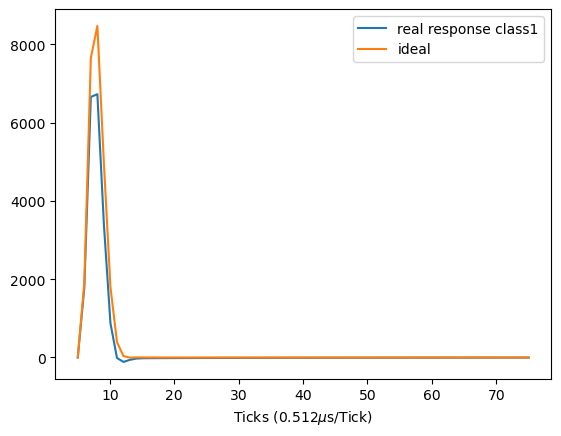

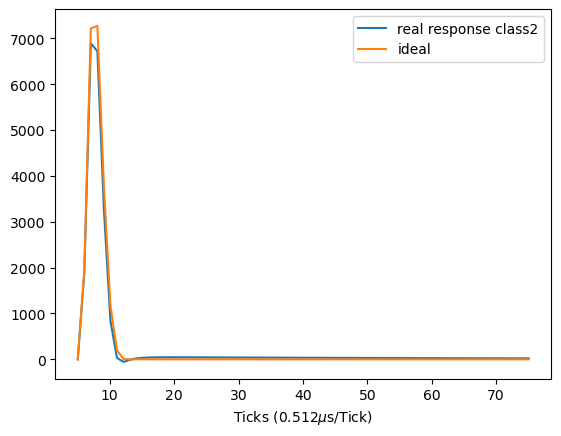

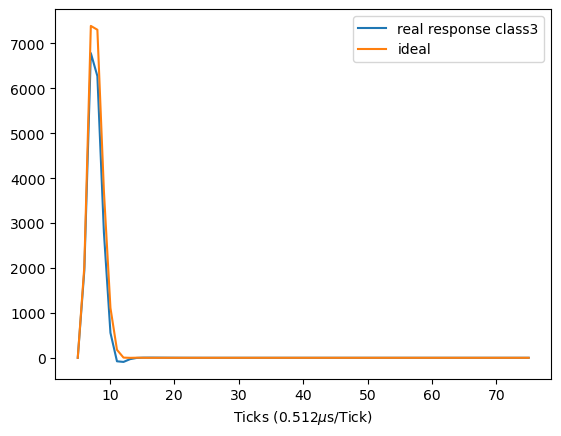

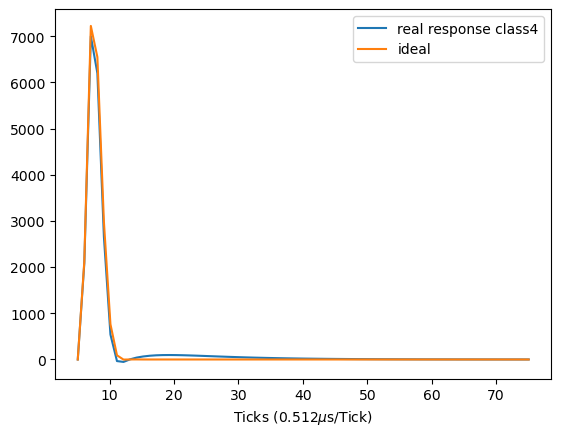

In [150]:
# class1
x = np.linspace(class1_df.copy().reset_index()['t'].iloc[2], class1_df.copy().reset_index()['t'].iloc[2]+70, 70)
par0 = list(class1_df.copy().reset_index()[response_params].iloc[2])
R = response(x=x, par=par0)
R_ideal = response_legacy(x=x, par=par0)

plt.figure()
plt.plot(x, R, label='real response class1')
plt.plot(x, R_ideal, label='ideal')
plt.xlabel('Ticks (0.512$\mu$s/Tick)')
plt.legend()
plt.show()

# class2
x = np.linspace(class2_df.copy().reset_index()['t'].iloc[2], class2_df.copy().reset_index()['t'].iloc[2]+70, 70)
par0 = list(class2_df.copy().reset_index()[response_params].iloc[2])
R = response(x=x, par=par0)
R_ideal = response_legacy(x=x, par=par0)

plt.figure()
plt.plot(x, R, label='real response class2')
plt.plot(x, R_ideal, label='ideal')
plt.xlabel('Ticks (0.512$\mu$s/Tick)')
plt.legend()
plt.show()

# class3
x = np.linspace(class3_df.copy().reset_index()['t'].iloc[2], class3_df.copy().reset_index()['t'].iloc[2]+70, 70)
par0 = list(class3_df.copy().reset_index()[response_params].iloc[2])
R = response(x=x, par=par0)
R_ideal = response_legacy(x=x, par=par0)

plt.figure()
plt.plot(x, R, label='real response class3')
plt.plot(x, R_ideal, label='ideal')
plt.xlabel('Ticks (0.512$\mu$s/Tick)')
plt.legend()
plt.show()

# class4
x = np.linspace(class4_df.copy().reset_index()['t'].iloc[2], class4_df.copy().reset_index()['t'].iloc[2]+70, 70)
par0 = list(class4_df.copy().reset_index()[response_params].iloc[2])
R = response(x=x, par=par0)
R_ideal = response_legacy(x=x, par=par0)

plt.figure()
plt.plot(x, R, label='real response class4')
plt.plot(x, R_ideal, label='ideal')
plt.xlabel('Ticks (0.512$\mu$s/Tick)')
plt.legend()
plt.show()

#### Merge the dataframes

In [151]:
output_df = pd.concat([class1_df, class2_df, class3_df, class4_df], axis=0)
output_df = output_df.reset_index().drop('index', axis=1)
output_df.to_csv('data/run_30413/run_30413_labelled_tails.csv', index=False)

In [152]:
class2_df

,#Ch.#,t,E(t),A_0,E(A_0),t_p,E(t_p),k3,E(k3),k4,E(k4),k5,E(k5),k6,E(k6),Chi2/DOF,integral_R,max_deviation,class
0,89,5.071445,0.009197,75147.93965,452.175,2.006376,0.007153,0.150477,0.002444,0.222196,0.004229,0.149931,0.002432,0.098308,0.001568,9.699528,0.0,0.122887,c2
1,801,5.115536,0.009538,73566.21594,453.519,2.024426,0.006894,0.094745,0.006232,0.082863,0.005236,0.071676,0.004455,0.082842,0.005247,15.286083,0.0,0.029646,c2
2,1699,5.039863,0.009069,80255.30535,629.450,2.147292,0.011624,0.584702,0.037414,0.649630,0.047017,0.017288,0.002286,0.014469,0.002131,1.188452,0.0,9.606648,c2
3,1724,5.047398,0.008673,75634.77506,472.257,2.068303,0.009189,0.474567,0.029367,0.515198,0.033739,0.029355,0.002601,0.025430,0.002368,2.878218,0.0,1.977514,c2
4,2037,5.029779,0.008940,78353.93419,563.304,2.110287,0.011773,0.617950,0.029081,0.705784,0.038652,0.045788,0.002511,0.041611,0.002293,2.198275,0.0,1.471128,c2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,9555,5.066872,0.009046,86749.52417,1905.990,2.151579,0.009254,1.522089,0.028731,1.860382,0.035697,0.016324,0.027787,0.016255,0.027747,5.812909,0.0,0.183341,c2
61,9567,5.080040,0.009104,87865.73103,1411.240,2.132893,0.008782,1.558670,0.028278,1.892117,0.035906,-0.003944,0.006621,-0.004137,0.006591,7.240128,0.0,0.186989,c2
62,9638,5.069580,0.009243,86565.44754,1338.150,2.201785,0.010059,1.513881,0.042081,1.859214,0.050097,-0.002620,0.009797,-0.002707,0.009776,4.156114,0.0,0.382268,c2
63,9737,5.094884,0.009329,74563.15445,445.205,2.113065,0.006788,0.121094,0.008860,0.110016,0.011890,0.099481,0.006988,0.109882,0.011207,6.116258,0.0,0.403049,c2
